In [1]:
# -- Bib
import os
import sys
sys.path.append("..")

import glob
from pathlib import Path
import networkx as nx
import geopandas as gpd
import pandas as pd
import datetime as dt
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
from dateutil.relativedelta import relativedelta
import mapclassify
from collections import defaultdict
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

idx = pd.IndexSlice

# -- base paths
basepath = Path.home().joinpath("Documents", "data")
cnespath = basepath.joinpath("opendatasus", "cnes")
geopath = basepath.joinpath("shapefilesceqgis")
simpath = basepath.joinpath("sim", "DBF")
gmlpath = basepath.joinpath("redes_aih")
ccapath = basepath.joinpath("cca_erneson")
figpath = gmlpath.joinpath("doc_final")

# -- load geo
geodata_df = gpd.read_parquet(geopath.joinpath("ce_geodata.parquet"))
ce_geodata_df = gpd.read_parquet(geopath.joinpath("ce_regiao_saude_municipios.parquet"))

pop_2022_ibge = pd.read_parquet(geopath.joinpath("pop_ce_2022_ibge.parquet"))
geodata_df = geodata_df.merge(pop_2022_ibge)

## **Regiões original - 5 divisões**

In [2]:
macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]

original_df = geodata_df.groupby("MACRO_ID")['pop_2022'].sum().reset_index()
macro_names_original = {1: 'Fortaleza', 2: 'Sertão Central', 3: 'Litoral Leste', 4: 'Norte', 5: 'Cariri'}
original_df["Macrorregião de Saúde"] = original_df["MACRO_ID"].map(macro_names_original)
original_df1 = original_df[["Macrorregião de Saúde", "pop_2022", "MACRO_ID"]].rename({'pop_2022': "População"}, axis=1)
original_df1 = original_df1.merge(macro_df[["MACRO_ID", "MACRO_COLOR"]])
original_df1["Pop. %"] = (original_df1["População"]/original_df1["População"].sum())*100
original_df1

,Macrorregião de Saúde,População,MACRO_ID,MACRO_COLOR,Pop. %
0,Fortaleza,4553473,1,#ef476f,51.773681
1,Sertão Central,618818,2,#ffb300,7.036055
2,Litoral Leste,530927,3,#04ae81,6.036721
3,Norte,1644010,4,#118ab2,18.692644
4,Cariri,1447729,5,#073b4c,16.460899


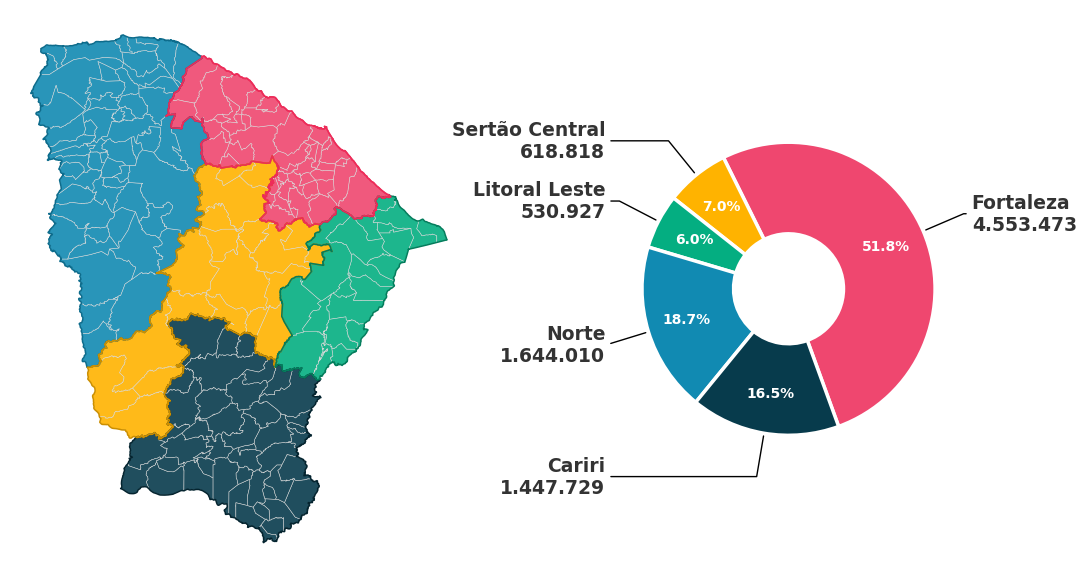

In [3]:
border_macro = {"#ef476f":"#ed2c59", "#073b4c":"#04242f", "#118ab2": "#0d6c8c", "#ffb300": "#cc8f00", "#04ae81": "#037d5c"}

# -- new geometry ceará
fig_new, (AX1, AX2) = plt.subplots(1,2, figsize=(13,8))

#geodata_df.set_geometry('geometry_municip').plot(ax=AX, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.6)
geodata_df.set_geometry('geometry_municip').plot(ax=AX1, color=geodata_df["MACRO_COLOR"], edgecolor="#d9d9d9", linewidth=0.4, alpha=0.9)

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=AX1, color="none", edgecolor=macro_df["MACRO_COLOR"].map(border_macro), linewidth=1.1)
macro_df[macro_df["MACRO_ID"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1.1)
AX1.axis('off')


## -- PIE CHART
radius = 0.8
values = original_df1["Pop. %"].tolist()
label_macro_name = original_df1["Macrorregião de Saúde"].tolist()
label_pop_abs = original_df1["População"].tolist()
wedges, texts, _ = AX2.pie(values, colors=original_df1["MACRO_COLOR"], startangle=-70, radius=radius, autopct='%1.1f%%', pctdistance=0.725,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='white', weight='bold', fontsize=10))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}\n{label_pop_abs[i]:,}".replace(",","."), xy=(x, y), fontsize=13.5, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)
#fig_new.savefig(basepath.joinpath("redes_aih", "doc_final", "pop_macro_original_pie.png"), dpi=250, bbox_inches='tight')

In [ ]:
# -- new geometry ceará
fig_new, (AX1) = plt.subplots(1,1, figsize=(8,10))

#geodata_df.set_geometry('geometry_municip').plot(ax=AX, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.6)
ce_geodata_df.set_geometry('geometry').plot(ax=AX1, color=ce_geodata_df["MACRO_ID"].map(proposal_color), edgecolor="#d9d9d9", linewidth=0.4, alpha=0.9)
#ce_geodata_df.set_geometry('geometry_regiao8')

ce_geodata_df.set_geometry('geometry_regiao10').plot(ax=AX1, color="none", edgecolor=ce_geodata_df["MACRO_ID"].map(proposal_color).map(border_proposal_macro), linewidth=1., alpha=0.9)
ce_geodata_df.set_geometry('geometry_regiao10')[ce_geodata_df["MACRO_ID"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1., alpha=0.9)

AX1.axis('off')

#macro_df = ce_geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "NOME_REGIAO_ORIGINAL", "geometry_original"]]
#macro_df = macro_df.set_geometry("geometry_original")
#macro_df.plot(ax=AX1, color="none", edgecolor=macro_df["MACRO_ID"].map(border_macro), linewidth=1.1)
#macro_df[macro_df["MACRO_ID"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1.1)
#AX1.axis('off')

mun_list = ["SOBRAL", "BARBALHA", "CRATO", "TAUÁ", "JUAZEIRO DO NORTE", "CRATEÚS", "IGUATU", "BATURITÉ", "ITAPIPOCA", "QUIXERAMOBIM", "RUSSAS", "LIMOEIRO DO NORTE", "FORTALEZA"]
sub_df = ce_geodata_df[ce_geodata_df["NM_MUN"].isin(mun_list)]
centroids = sub_df["geometry"].representative_point()
centroids.plot(ax=AX1, facecolor="white", edgecolor="#333333", linewidth=1.2, markersize=20)

for index, point in enumerate(centroids.values):
    label = sub_df["NM_MUN"].iat[index]
    if label not in ["BARBALHA", "CRATO", "JUAZEIRO DO NORTE"]:
        AX1.annotate(label, xy=(point.x*1.005, point.y+0.05), fontsize=10, color="#262626", weight="bold")
    else:
        AX1.annotate(label, xy=(point.x*1.005, point.y+0.05), fontsize=10, color="#262626", weight="bold")

fig_new.savefig(basepath.joinpath("redes_aih", "doc_final", "pop_macro_original_pie_single.png"), dpi=250, bbox_inches='tight')

In [10]:
ce_geodata_df["geometry"].centroid

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_14592\3427704525.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ce_geodata_df["geometry"].centroid


0      POINT (-39.03682 -7.36057)
1      POINT (-39.69930 -6.98561)
2      POINT (-39.98127 -6.75649)
3      POINT (-40.07654 -7.23928)
4      POINT (-39.86923 -6.90963)
                  ...            
179    POINT (-39.84684 -5.49700)
180    POINT (-38.94703 -4.95448)
181    POINT (-39.33321 -5.24555)
182    POINT (-39.43364 -5.58767)
183    POINT (-39.00243 -5.77647)
Length: 184, dtype: geometry

## **Região - 8 divisões**

In [25]:
proposal_color = {1: "#ef476f", 3: "#073b4c", 6:"#04ae81", 8:"#118ab2", 5: "#ffb300",
                  2: "#f48ada", 4: "#ef7347", 7:"#14b1eb"}

border_proposal_macro = {"#ef476f":"#ed2c59", "#073b4c":"#04242f", "#118ab2": "#0d6c8c", 
                         "#ffb300": "#cc8f00", "#04ae81": "#037d5c", "#14b1eb":"#108ebc",
                         "#f48ada": "#f05ccb", "#ef7347": "#ed5f2c"}

proposal_df = ce_geodata_df.groupby("REGIAO_SAUDE_8")['2022'].sum().reset_index()
name_macro = {
    1: "Grande Fortaleza\nBaturité", 2: "Litoral Oeste\nVale do Curu\nLitoral Norte",
    3: "Cariri", 4: "Centro Sul", 5: "Sertão Central", 6: "Litoral Leste - Jaguaribe",
    7: "Sertão dos Inhamuns\nCrateús", 8: "Serra da Ibiapaba\nSertão de Sobral"
}
#name_macro = {
#    1: "Grande Fortaleza\nBaturité", 2: "Litoral Oeste\nLitoral Norte",
#    3: "Cariri", 4: "Centro Sul", 5: "Sertão Central", 6: "Litoral Leste\nJaguaribe",
#    7: "Sertão dos Inhamuns\nCrateús", 8: "Serra da Ibiapaba\nSertão de Sobral"
#}
proposal_df["Macrorregião de Saúde"] = proposal_df["REGIAO_SAUDE_8"].map(name_macro)
proposal_df1 = proposal_df[["Macrorregião de Saúde", "2022", "REGIAO_SAUDE_8"]].rename({'2022': "População"}, axis=1).sample(frac=1.0, random_state=2)
proposal_df1["Pop. %"] = (proposal_df1["População"]/proposal_df1["População"].sum())*100
proposal_df1["MACRO_COLOR"] = proposal_df1["REGIAO_SAUDE_8"].map(proposal_color)
proposal_df1

,Macrorregião de Saúde,População,REGIAO_SAUDE_8,Pop. %,MACRO_COLOR
4,Sertão Central,504459.0,5,5.737908,#ffb300
1,Litoral Oeste\nVale do Curu\nLitoral Norte,977233.0,2,11.115419,#f48ada
6,Sertão dos Inhamuns\nCrateús,475024.0,7,5.403103,#14b1eb
2,Cariri,961371.0,3,10.934999,#073b4c
3,Centro Sul,486338.0,4,5.531793,#ef7347
7,Serra da Ibiapaba\nSertão de Sobral,860799.0,8,9.791055,#118ab2
5,Litoral Leste - Jaguaribe,583818.0,6,6.640568,#04ae81
0,Grande Fortaleza\nBaturité,3942646.0,1,44.845154,#ef476f


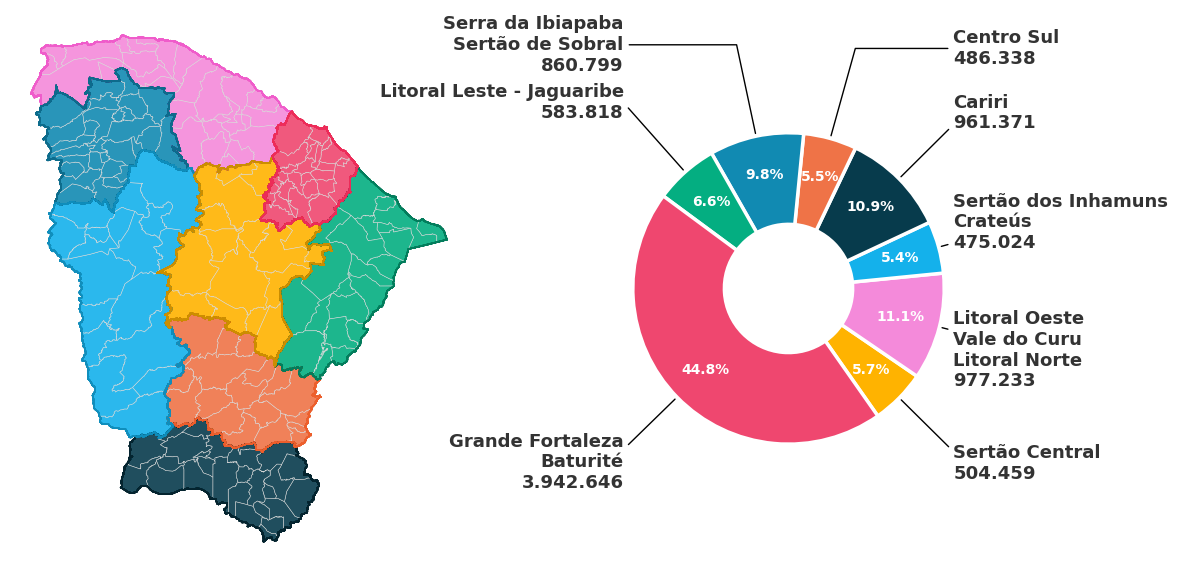

In [26]:
# -- new geometry ceará
fig_new, (AX1, AX2) = plt.subplots(1,2, figsize=(13,8))

#geodata_df.set_geometry('geometry_municip').plot(ax=AX, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.6)
ce_geodata_df.set_geometry('geometry').plot(ax=AX1, color=ce_geodata_df["REGIAO_SAUDE_8"].map(proposal_color), edgecolor="#d9d9d9", linewidth=0.4, alpha=0.9)
#ce_geodata_df.set_geometry('geometry_regiao8')

ce_geodata_df.set_geometry('geometry_regiao8').plot(ax=AX1, color="none", edgecolor=ce_geodata_df["REGIAO_SAUDE_8"].map(proposal_color).map(border_proposal_macro), linewidth=1., alpha=0.9)
ce_geodata_df.set_geometry('geometry_regiao8')[ce_geodata_df["REGIAO_SAUDE_8"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1., alpha=0.9)

AX1.axis('off')

## -- PIE CHART
radius = 0.85
values = proposal_df1["Pop. %"].tolist()
label_macro_name = proposal_df1["Macrorregião de Saúde"].tolist()
label_pop_abs = proposal_df1["População"].tolist()
wedges, texts, _ = AX2.pie(values, colors=proposal_df1["MACRO_COLOR"], startangle=-55, radius=radius, autopct='%1.1f%%', pctdistance=0.745,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='white', weight='bold', fontsize=10.))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}\n{label_pop_abs[i]:,.0f}".replace(",","."), xy=(x, y), fontsize=13., weight='bold', xytext=(0.9*np.sign(x), 1.6*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]}", xy=(x, 1.2*y), fontsize=12, weight='bold', xytext=(1.0*np.sign(x), 1.3*y),
    #            horizontalalignment=horizontalalignment)
fig_new.savefig(basepath.joinpath("redes_aih", "doc_final", "pop_macro_proposta_pie.png"), dpi=250, bbox_inches='tight')

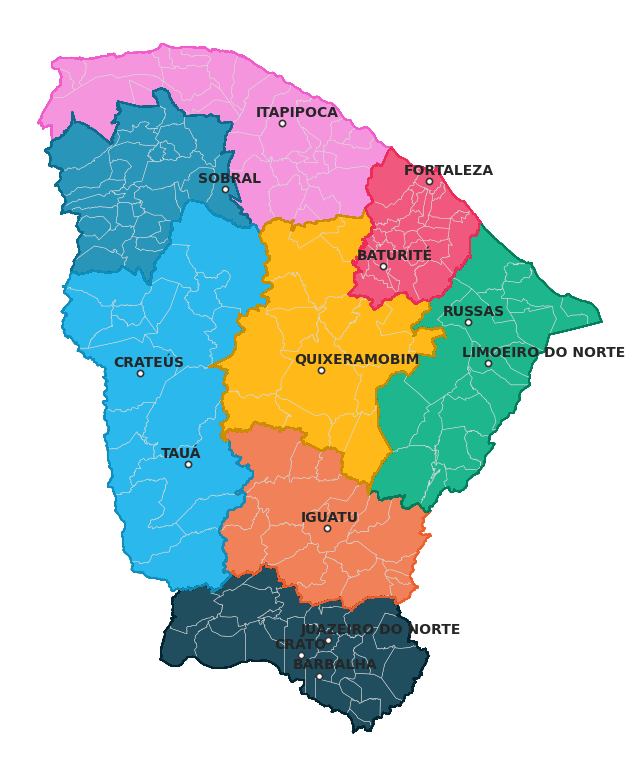

In [83]:
# -- new geometry ceará
fig_new, (AX1) = plt.subplots(1,1, figsize=(8,10))

#geodata_df.set_geometry('geometry_municip').plot(ax=AX, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.6)
ce_geodata_df.set_geometry('geometry').plot(ax=AX1, color=ce_geodata_df["REGIAO_SAUDE_8"].map(proposal_color), edgecolor="#d9d9d9", linewidth=0.4, alpha=0.9)
#ce_geodata_df.set_geometry('geometry_regiao8')

ce_geodata_df.set_geometry('geometry_regiao8').plot(ax=AX1, color="none", edgecolor=ce_geodata_df["REGIAO_SAUDE_8"].map(proposal_color).map(border_proposal_macro), linewidth=1., alpha=0.9)
ce_geodata_df.set_geometry('geometry_regiao8')[ce_geodata_df["REGIAO_SAUDE_8"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1., alpha=0.9)

AX1.axis('off')

#macro_df = ce_geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "NOME_REGIAO_ORIGINAL", "geometry_original"]]
#macro_df = macro_df.set_geometry("geometry_original")
#macro_df.plot(ax=AX1, color="none", edgecolor=macro_df["MACRO_ID"].map(border_macro), linewidth=1.1)
#macro_df[macro_df["MACRO_ID"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1.1)
#AX1.axis('off')

mun_list = ["SOBRAL", "BARBALHA", "CRATO", "TAUÁ", "JUAZEIRO DO NORTE", "CRATEÚS", "IGUATU", "BATURITÉ", "ITAPIPOCA", "QUIXERAMOBIM", "RUSSAS", "LIMOEIRO DO NORTE", "FORTALEZA"]
sub_df = ce_geodata_df[ce_geodata_df["NM_MUN"].isin(mun_list)]
centroids = sub_df["geometry"].representative_point()
centroids.plot(ax=AX1, facecolor="white", edgecolor="#333333", linewidth=1.2, markersize=20)

for index, point in enumerate(centroids.values):
    label = sub_df["NM_MUN"].iat[index]
    if label not in ["BARBALHA", "CRATO", "JUAZEIRO DO NORTE"]:
        AX1.annotate(label, xy=(point.x*1.005, point.y+0.05), fontsize=10, color="#262626", weight="bold")
    else:
        AX1.annotate(label, xy=(point.x*1.005, point.y+0.05), fontsize=10, color="#262626", weight="bold")

fig_new.savefig(basepath.joinpath("redes_aih", "doc_final", "pop_macro_proposta_pie_single.png"), dpi=250, bbox_inches='tight')

In [39]:
centroids.values

<GeometryArray>
[<POINT (-39.347 -7.439)>, <POINT (-39.482 -7.289)>, <POINT (-39.282 -7.179)>,
 <POINT (-39.283 -6.353)>, <POINT (-38.528 -3.793)>, <POINT (-39.616 -3.367)>,
 <POINT (-38.096 -5.136)>, <POINT (-38.242 -4.835)>, <POINT (-40.044 -3.857)>,
 <POINT (-40.667 -5.209)>,  <POINT (-39.33 -5.187)>]
Length: 11, dtype: geometry

## **Região - 10 divisões**

In [85]:
proposal_color = {1: "#ef476f", 4: "#073b4c", 7:"#04ae81", 10:"#118ab2", 6: "#ffb300",
                  3: "#f48ada", 5: "#ef7347", 8:"#14b1eb", 9: "#929af2", 2: "#285983"}

border_proposal_macro = {"#ef476f":"#ed2c59", "#073b4c":"#04242f", "#118ab2": "#0d6c8c", 
                         "#ffb300": "#cc8f00", "#04ae81": "#037d5c", "#14b1eb":"#108ebc",
                         "#f48ada": "#f05ccb", "#ef7347": "#ed5f2c", "#929af2": "#7680ef",
                         "#285983": "#306a9c"}

proposal_df = ce_geodata_df.groupby("REGIAO_SAUDE_10")['2022'].sum().reset_index()
name_macro = {
    1: 'Fortaleza', 2: 'Baturité', 3: 'Litoral Oeste\nVale do Curu',
    4: 'Cariri', 5: 'Centro Sul', 6: 'Sertão Central', 7: 'Litoral Leste\nJaguaribe',
    8: 'Sertão dos Inhamuns\nCrateús', 9: 'Litoral Norte', 10: 'Sertão de Sobral' 
}
proposal_df["Macrorregião de Saúde"] = proposal_df["REGIAO_SAUDE_10"].map(name_macro)
proposal_df1 = proposal_df[["Macrorregião de Saúde", "2022", "REGIAO_SAUDE_10"]].rename({'2022': "População"}, axis=1).sample(frac=1.0, random_state=2)
proposal_df1["Pop. %"] = (proposal_df1["População"]/proposal_df1["População"].sum())*100
proposal_df1["MACRO_COLOR"] = proposal_df1["REGIAO_SAUDE_10"].map(proposal_color)
proposal_df1

,Macrorregião de Saúde,População,REGIAO_SAUDE_10,Pop. %,MACRO_COLOR
4,Centro Sul,486338.0,5,5.531793,#ef7347
1,Baturité,232866.0,2,2.648706,#285983
5,Sertão Central,504459.0,6,5.737908,#ffb300
0,Fortaleza,3845530.0,1,43.740519,#ef476f
7,Sertão dos Inhamuns\nCrateús,475024.0,8,5.403103,#14b1eb
2,Litoral Oeste\nVale do Curu,443896.0,3,5.049042,#f48ada
3,Cariri,961371.0,4,10.934999,#073b4c
6,Litoral Leste\nJaguaribe,583818.0,7,6.640568,#04ae81
9,Sertão de Sobral,483638.0,10,5.501082,#118ab2
8,Litoral Norte,774748.0,9,8.812278,#929af2


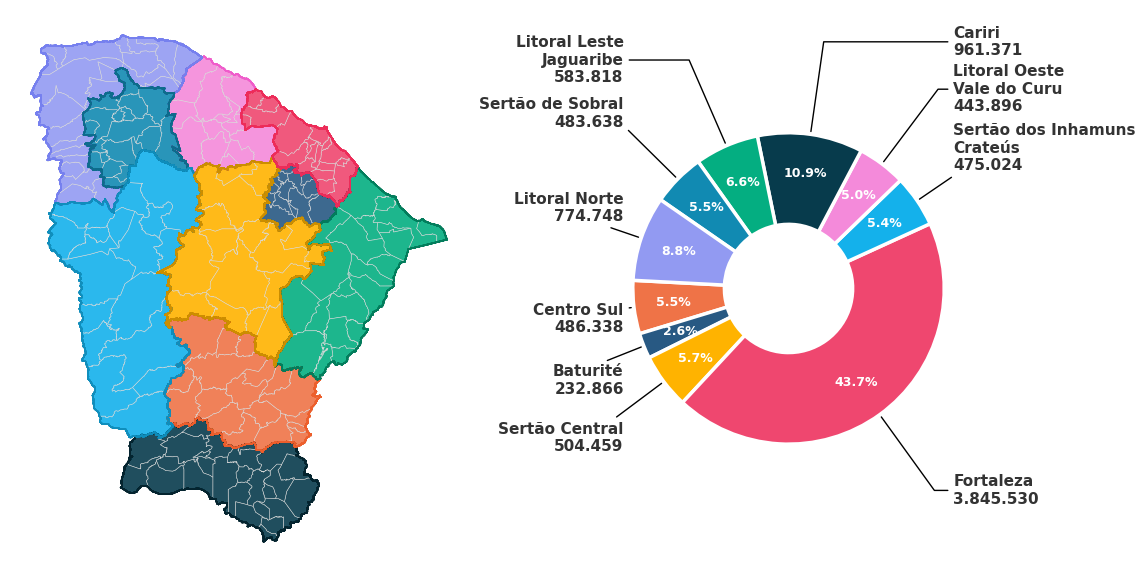

In [86]:
# -- new geometry ceará
fig_new, (AX1, AX2) = plt.subplots(1,2, figsize=(13,8))

#geodata_df.set_geometry('geometry_municip').plot(ax=AX, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.6)
ce_geodata_df.set_geometry('geometry').plot(ax=AX1, color=ce_geodata_df["REGIAO_SAUDE_10"].map(proposal_color), edgecolor="#d9d9d9", linewidth=0.4, alpha=0.9)
#ce_geodata_df.set_geometry('geometry_regiao8')

ce_geodata_df.set_geometry('geometry_regiao10').plot(ax=AX1, color="none", edgecolor=ce_geodata_df["REGIAO_SAUDE_10"].map(proposal_color).map(border_proposal_macro), linewidth=1., alpha=0.9)
ce_geodata_df.set_geometry('geometry_regiao10')[ce_geodata_df["REGIAO_SAUDE_10"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1., alpha=0.9)

AX1.axis('off')

## -- PIE CHART
radius = 0.85
values = proposal_df1["Pop. %"].tolist()
label_macro_name = proposal_df1["Macrorregião de Saúde"].tolist()
label_pop_abs = proposal_df1["População"].tolist()
wedges, texts, _ = AX2.pie(values, colors=proposal_df1["MACRO_COLOR"], startangle=-183, radius=radius, autopct='%1.1f%%', pctdistance=0.745,
                        wedgeprops=dict(width=0.5, edgecolor='w', linewidth=2.5), textprops=dict(color='white', weight='bold', fontsize=9.))

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.82)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = radius*np.sin(np.deg2rad(ang))
    x = radius*np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    AX2.annotate(f"{label_macro_name[i]}\n{label_pop_abs[i]:,.0f}".replace(",","."), xy=(x, y), fontsize=11., weight='bold', xytext=(0.9*np.sign(x), 1.6*y),
                horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_macro_name[i]}\n ".replace(",","."), xy=(x, y), fontsize=11., weight='bold', xytext=(0.9*np.sign(x), 1.6*y),
    #            horizontalalignment=horizontalalignment, color="#333333", **kw)
    #AX2.annotate(f"{label_pop_abs[i]:,.0f}".replace(",","."), xy=(x, y), fontsize=11., weight='bold', xytext=(0.9*np.sign(x), 1.5*y),
    #             color="#333333", horizontalalignment=horizontalalignment)
fig_new.savefig(basepath.joinpath("redes_aih", "doc_final", "pop_macro_proposta10_pie.png"), dpi=250, bbox_inches='tight')

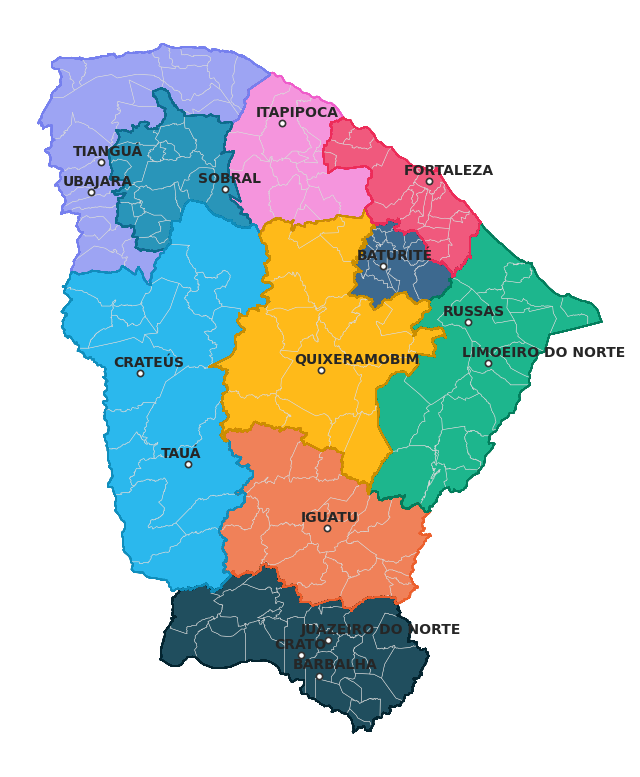

In [89]:
# -- new geometry ceará
fig_new, (AX1) = plt.subplots(1,1, figsize=(8,10))

#geodata_df.set_geometry('geometry_municip').plot(ax=AX, color="#ffffff", edgecolor="#d9d9d9", linewidth=0.6)
ce_geodata_df.set_geometry('geometry').plot(ax=AX1, color=ce_geodata_df["REGIAO_SAUDE_10"].map(proposal_color), edgecolor="#d9d9d9", linewidth=0.4, alpha=0.9)
#ce_geodata_df.set_geometry('geometry_regiao8')

ce_geodata_df.set_geometry('geometry_regiao10').plot(ax=AX1, color="none", edgecolor=ce_geodata_df["REGIAO_SAUDE_10"].map(proposal_color).map(border_proposal_macro), linewidth=1., alpha=0.9)
ce_geodata_df.set_geometry('geometry_regiao10')[ce_geodata_df["REGIAO_SAUDE_10"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1., alpha=0.9)

AX1.axis('off')

#macro_df = ce_geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "NOME_REGIAO_ORIGINAL", "geometry_original"]]
#macro_df = macro_df.set_geometry("geometry_original")
#macro_df.plot(ax=AX1, color="none", edgecolor=macro_df["MACRO_ID"].map(border_macro), linewidth=1.1)
#macro_df[macro_df["MACRO_ID"]==1].plot(ax=AX1, color="none", edgecolor="#ed2c59", linewidth=1.1)
#AX1.axis('off')

mun_list = ["SOBRAL", "BARBALHA", "CRATO", "TAUÁ", "JUAZEIRO DO NORTE", "CRATEÚS", "IGUATU", "BATURITÉ", "UBAJARA", "TIANGUÁ", "ITAPIPOCA", "QUIXERAMOBIM", "RUSSAS", "LIMOEIRO DO NORTE", "FORTALEZA"]
sub_df = ce_geodata_df[ce_geodata_df["NM_MUN"].isin(mun_list)]
centroids = sub_df["geometry"].representative_point()
centroids.plot(ax=AX1, facecolor="white", edgecolor="#333333", linewidth=1.2, markersize=20)

for index, point in enumerate(centroids.values):
    label = sub_df["NM_MUN"].iat[index]
    if label not in ["BARBALHA", "CRATO", "JUAZEIRO DO NORTE"]:
        AX1.annotate(label, xy=(point.x*1.005, point.y+0.05), fontsize=10, color="#262626", weight="bold")
    else:
        AX1.annotate(label, xy=(point.x*1.005, point.y+0.05), fontsize=10, color="#262626", weight="bold")

fig_new.savefig(basepath.joinpath("redes_aih", "doc_final", "pop_macro_proposta10_pie_single.png"), dpi=250, bbox_inches='tight')